# Outline of notebook

In this Notebook I compute the rate and distortions of a set of models on the validation set. 

The runs vary in: 
* Latent space size: 32 & 64
* Objective: $\beta$-VAE or autoencoder
* Free-bits: 0.0 (normal VAE), 0.25, 0.5, 0.75, 1.0, 1.5

The rate is the average KL-divergence from prior to posterior and the distortion the average reconstruction loss.

The rate and distortion together make up the ELBO, but since the ELBO does not set any preference over the the two when minimising the sum (the ELBO), the results need to be judged on the basis of the two quantities separately. Also the trade-off between the two is interesting to look into.

# Imports

In [1]:
import sys; sys.path.append("../")
from dataset_wrappper import NewsData
from utils_train import transfer_batch_to_device
import os
from run_validation import load_model_for_eval
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast
import torch
from utils_evaluation import tokenizer_batch_decode
import numpy as np
import pickle
import pandas as pd

plt.style.reload_library()
plt.style.use('thesis_style')

%matplotlib inline

# Globals

In [2]:
BATCH_SIZE = 64
DEVICE = "cuda:0"
CHECKPOINT_TYPE = "best" # else "best"
RESULT_DIR = Path("result-files")

# Data, data loader and tokenizer

In [4]:
data = NewsData(batch_size=BATCH_SIZE, tokenizer_name="roberta", dataset_name="ptb_text_only", max_seq_len=64)
validation_loader = data.val_dataloader(batch_size=BATCH_SIZE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Is file!
train 42068
validation 3370
test 3761


# Fetch the model paths we want to evaluate

In [5]:
def get_clean_name(run_name):
    latent_size = run_name.split("-")[4][-2:]
    if "autoencoder" in run_name:
        FB = "autoencoder"
    else:
        FB = run_name.split("-")[6]
        if len(FB) == 3:
            FB += "0"
        FB = "FB-" + FB
    clean_name = f"NZ-{latent_size} | {FB}"
    return clean_name

In [6]:
PTB_run_name_paths = {}
for r in os.listdir("../Runs"):
    if "PTB" in r:
        path = Path("../Runs") / r / f"checkpoint-{CHECKPOINT_TYPE}.pth"
        PTB_run_name_paths[r] = path

clean_names = []
for r in PTB_run_name_paths.keys():
#     print(get_clean_name(r))
    clean_names.append(get_clean_name(r))
    
clean_names = sorted(clean_names)

# Evaluate the distortion, rate and ELBO on the validation in two modes: 
* parallel w. teacher forcing, 
* recurrent w. no teacher forcing

In [7]:
results_rate_distortion = {}

for AUTO_REGRESSIVE in [False, True]:
    MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'
    RESULT_FILE_PPL = RESULT_DIR / f"result_rate_distortion_{MODE}.pickle"

    if os.path.exists(RESULT_FILE_PPL):
        print(f"Loading file {RESULT_FILE_PPL}, it existed.")
        res_dict = pickle.load( open( RESULT_FILE_PPL, "rb" ) )
    else:
        res_dict = {}
    
    for i, (r, p) in enumerate(PTB_run_name_paths.items()):
        print(i, r)
        
        if r in results_ppl:
            print("Skipping this run, already in result dict!")
            continue

        elbo = []
        distortion = []
        rate = []

        latent_size = int(r.split("-")[4][-2:])

        vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                        latent_size=latent_size, 
                                        add_latent_via_memory=True,
                                        add_latent_via_embeddings=False, 
                                        do_tie_weights=True, 
                                        do_tie_embedding_spaces=True,
                                        add_decoder_output_embedding_bias=False)


        N = len(validation_loader)
        with torch.no_grad():
            for batch_i, batch in enumerate(validation_loader):
                print(f"{batch_i:3d}/{N}", end="\r")
                batch = transfer_batch_to_device(batch, DEVICE)
                vae_output = vae_model.forward(batch["input_ids"], 
                                               1.0, 
                                               batch["attention_mask"],
                                               auto_regressive=AUTO_REGRESSIVE,
                                               objective="beta-vae",
                                               hinge_kl_loss_lambda=0.0,
                                               return_cross_entropy=True,
                                               reduce_seq_dim_ce="sum",
                                               reduce_batch_dim_ce="mean",
                                               reduce_seq_dim_exact_match="none",
                                               nucleus_sampling=False,
                                               device_name="cuda:0",
                                               decode_sample_from_prior=False)

                elbo.append(vae_output["-ELBO"])    
                distortion.append(vae_output["recon_loss"])
                rate.append(vae_output["kl_loss"])

        res_dict[r] ={
            "elbo": elbo,
            "rate": rate,
            "distortion": distortion
        }

        pickle.dump( res_dict, open( RESULT_FILE_PPL, "wb" ) )
    
    results_rate_distortion[MODE] = res_dict

Loading file result-files/result_rate_distortion_TF.pickle, it existed.
0 2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Skipping this run, already in result dict!
1 2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Skipping this run, already in result dict!
2 2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Skipping this run, already in result dict!
3 2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Skipping this run, already in result dict!
4 2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Skipping this run, already in result dict!
5 2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Skipping this run, already in result dict!
6 2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Skipping this run, already in result dict!
7 2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Skipping this run, already in result dict!
8 2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
Skipping this run, already in result dict!
9 2021-02-03-PTB-latent64-autoencoder-run-18:25:57
Skipping this run, already in result dict!
10 2021-02-02-PTB-laten

TF


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


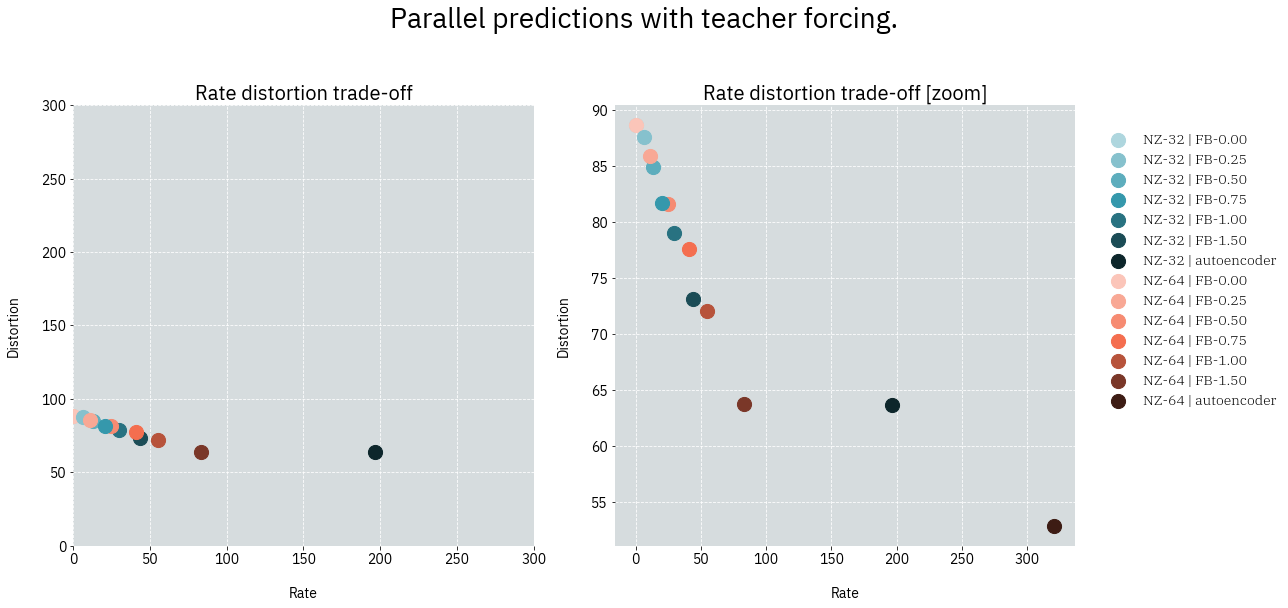

AR


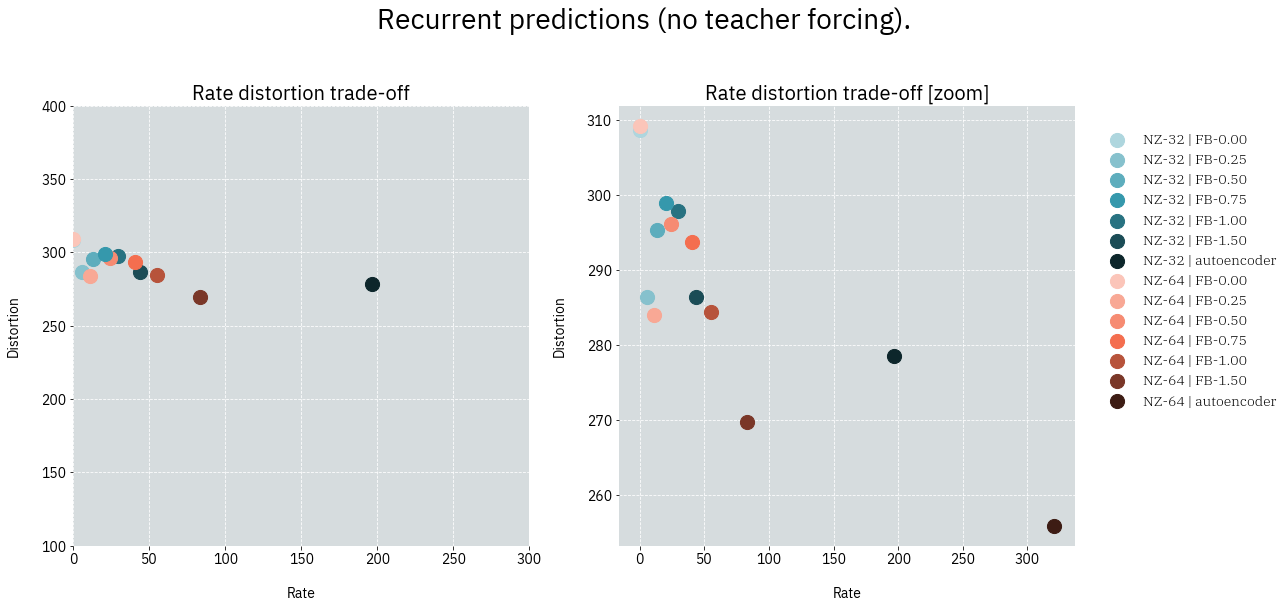

In [11]:
MODE = "TF"

nz_32_c = {
    "autoencoder":"#0D262B", 
    "FB-0.00":"#AED6DE",
    "FB-0.25":"#86C1CD",
    "FB-0.50":"#5DADBD", 
    "FB-0.75":"#3598AC", 
    "FB-1.00":"#287281", 
    "FB-1.50":"#1B4C56"}

nz_64_c = {
    "autoencoder":"#3D1C14", 
    "FB-0.00":"#FBC5B9",
    "FB-0.25":"#F8A895",
    "FB-0.50":"#F68B72", 
    "FB-0.75":"#F46E4F", 
    "FB-1.00":"#B7533B", 
    "FB-1.50":"#7A3728"}

order = []
for MODE in ["TF", "AR"]:
    print(MODE)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    for name, r in rate_distortion_results[MODE].items():
        if "64" in name:
            c = nz_64_c[name.split(" | ")[1]]
        else:
            c = nz_32_c[name.split(" | ")[1]]
        ax[0].scatter([r["rate_mean"]], [r["dist_mean"]], s=200, label=name, c=c)

    ax[0].set_xlabel("Rate")
    ax[0].set_ylabel("Distortion")
    ax[0].set_title("Rate distortion trade-off")
    
    if MODE == "TF":
        ax[0].set_xlim([0, 300])
        ax[0].set_ylim([0, 300])
    else:
        ax[0].set_xlim([0, 300])
        ax[0].set_ylim([100, 400])

    paths = []
    labels = []

    for name, r in rate_distortion_results[MODE].items():
        if "64" in name:
            c = nz_64_c[name.split(" | ")[1]]
        else:
            c = nz_32_c[name.split(" | ")[1]]
        p = ax[1].scatter([r["rate_mean"]], [r["dist_mean"]], s=200, label=name, c=c)
        paths.append(p)
        labels.append(name)
        
    order = [labels.index(c) for c in clean_names]
    paths_ordered = [paths[o] for o in order]
    labels_ordered = [labels[o] for o in order]

    ax[1].set_xlabel("Rate")
    ax[1].set_ylabel("Distortion")
    ax[1].set_title("Rate distortion trade-off [zoom]")
    ax[1].legend(paths_ordered, labels_ordered, loc=(1.05, 0.3), prop={'family':'serif','weight':300, 'size':14})
    
    if MODE == 'TF':
        plt.suptitle("Parallel predictions with teacher forcing.", size=28, y=1.05)
    else:
        plt.suptitle("Recurrent predictions (no teacher forcing).", size=28, y=1.05)
    
    plt.tight_layout()
    plt.savefig(RESULT_DIR / f"rate_distortion_{MODE}.png", dpi=300, bbox="tight_inches")
    plt.show()

TF


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


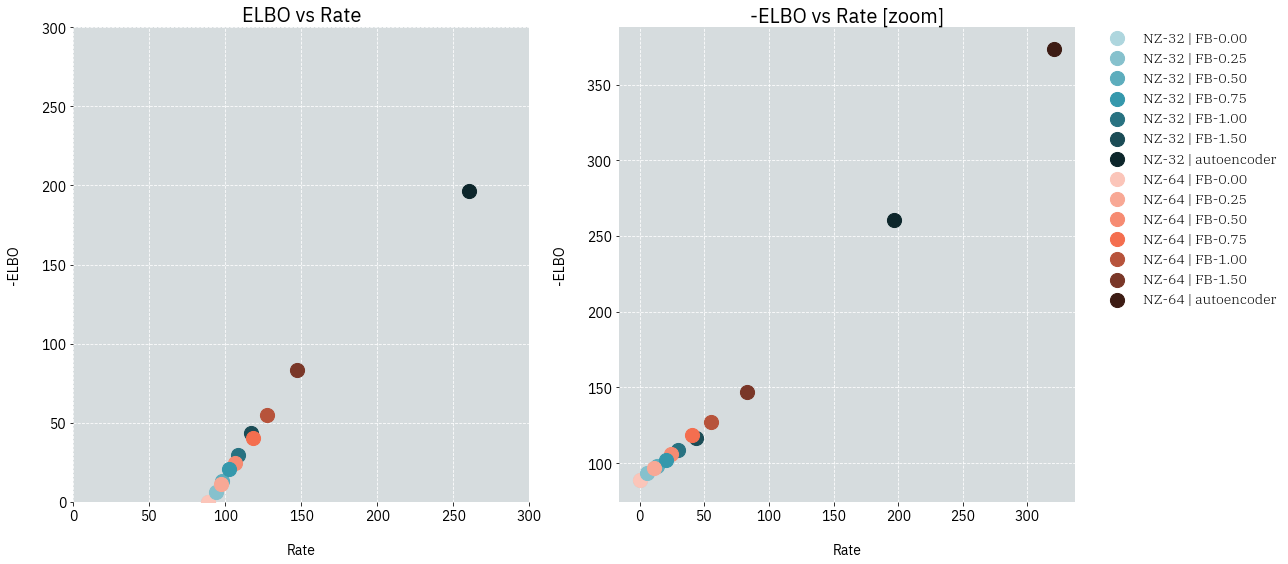

AR


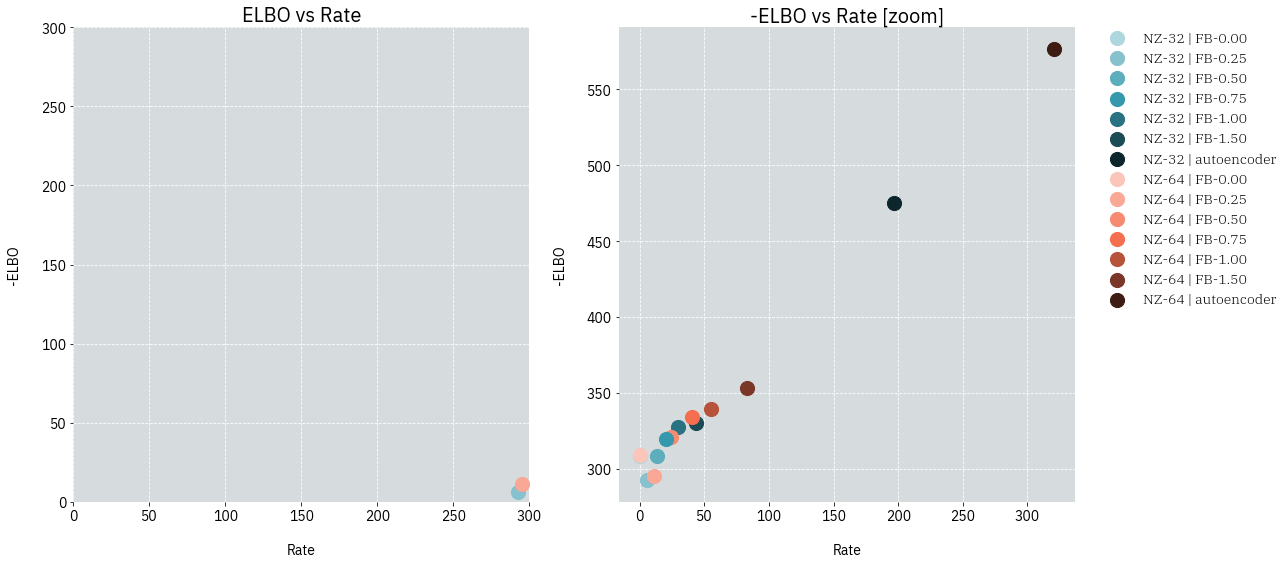

In [23]:

# for name, r in results_ppl.items():
#     rate, dist = np.mean(r["rate"]), np.mean(r["distortion"])
#     ax.scatter([rate], [dist], label=get_clean_name(name), s=200) 

nz_32_c = {
    "autoencoder":"#0D262B", 
    "FB-0.00":"#AED6DE",
    "FB-0.25":"#86C1CD",
    "FB-0.50":"#5DADBD", 
    "FB-0.75":"#3598AC", 
    "FB-1.00":"#287281", 
    "FB-1.50":"#1B4C56"}

nz_64_c = {
    "autoencoder":"#3D1C14", 
    "FB-0.00":"#FBC5B9",
    "FB-0.25":"#F8A895",
    "FB-0.50":"#F68B72", 
    "FB-0.75":"#F46E4F", 
    "FB-1.00":"#B7533B", 
    "FB-1.50":"#7A3728"}


for MODE in ["TF", "AR"]:
    print(MODE)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    
    paths = []
    labels = []

    for name, r in rate_distortion_results[MODE].items():
        if "64" in name:
            c = nz_64_c[name.split(" | ")[1]]
        else:
            c = nz_32_c[name.split(" | ")[1]]
        p = ax[0].scatter([r["-elbo_mean"]], [r["rate_mean"]], s=200, label=name, c=c)
        paths.append(p)
        labels.append(name)
        
    order = [labels.index(c) for c in clean_names]
    paths_ordered = [paths[o] for o in order]
    labels_ordered = [labels[o] for o in order]

    ax[0].set_xlabel("Rate")
    ax[0].set_ylabel("-ELBO")
    ax[0].set_title("ELBO vs Rate")
    ax[0].set_xlim([0, 300])
    ax[0].set_ylim([0, 300])

    for name, r in rate_distortion_results[MODE].items():
        if "64" in name:
            c = nz_64_c[name.split(" | ")[1]]
        else:
            c = nz_32_c[name.split(" | ")[1]]
        ax[1].scatter([r["rate_mean"]], [r["-elbo_mean"]], s=200, label=name, c=c)


    # for name, r in rate_distortion_results.items():
    #     if "64" in name:
    #         c = nz_64_c[name.split(" | ")[1]]
    #     else:
    #         c = nz_32_c[name.split(" | ")[1]]


    # ax[1].set_xlabel("Rate")
    # ax[1].set_ylabel("Distortion")
    ax[1].set_title("-ELBO vs Rate [zoom]")
    ax[1].set_xlabel("Rate")
    ax[1].set_ylabel("-ELBO")
    ax[1].legend(paths_ordered, labels_ordered, loc=(1.05, 0.4), prop={'family':'serif','weight':300, 'size':14})
    plt.tight_layout()
    plt.savefig(RESULT_DIR / f"elbo_rate_{MODE}.png", dpi=300, bbox="tight_inches")
    plt.show()